In [1]:
import numpy as np
import pandas as pd

In [2]:
# load files
pr_df = pd.read_csv("./raw/Pressure.csv", header=None)
vl_df = pd.read_csv("./raw/Volume.csv", header=None)
# set columns
pr_df.columns = ["x", "y"]
vl_df.columns = ["x", "y"]


<AxesSubplot:xlabel='x', ylabel='y'>

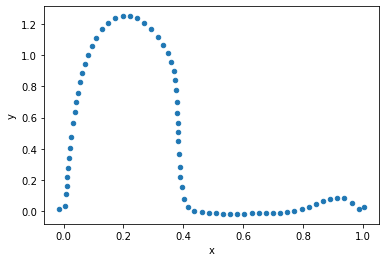

In [3]:
pr_df.plot(x="x", y="y", kind="scatter")

<AxesSubplot:xlabel='x', ylabel='y'>

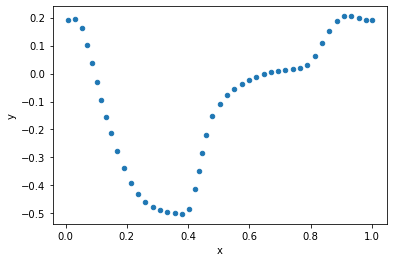

In [4]:
vl_df.plot(x="x", y="y", kind="scatter")

## Adjust Dataset

In [5]:
def m3_avg(arr, reshape=True):
    for i in range(len(arr) - 2):
        x1 = arr[i]
        x2 = arr[i+1]
        x3 = arr[i+2]
        x2 = (x1 + x3) / 2
        arr[i+1] = x2
    if reshape == True:
        return arr.reshape((len(arr), ))
    return arr

In [6]:
# crop data that is x < 0
pr_df.drop(pr_df[pr_df["x"] < 0].index, inplace=True)
vl_df.drop(vl_df[vl_df["x"] < 0].index, inplace=True)

# crop data that is x > 1
pr_df.drop(pr_df[pr_df["x"] > 1].index, inplace=True)
vl_df.drop(vl_df[vl_df["x"] > 1].index, inplace=True)

In [7]:
# Adjust pressure range (min pressure is zero)
pr_df["y"] = pr_df["y"] + (-pr_df["y"].min())
# fix start and end points
pr_df["y"].loc[1] = 0.0
pr_df["y"].loc[len(pr_df)] = 0.0
pr_df["x"].loc[1] = 0.0
pr_df["x"].loc[len(pr_df)] = 1.0

In [8]:
# Average dataset in x and y by median of 3 values
pr_df["x"][::] = m3_avg(pr_df["x"].values)
pr_df["y"][::] = m3_avg(pr_df["y"].values)

<AxesSubplot:xlabel='x', ylabel='y'>

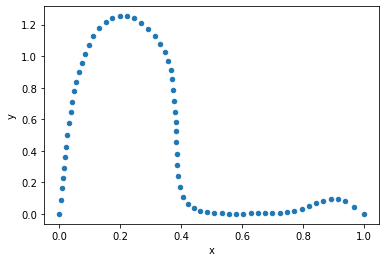

In [9]:
pr_df.plot(x="x", y="y", kind="scatter")

In [10]:
# Adjust volume range (max volume is 1.0)
vl_df["y"] = (vl_df["y"] - vl_df["y"].max()) + 1.0
# fix start and end points
vl_df["y"][0:2] = 1.0
vl_df["y"][-3:] = 1.0
vl_df["x"][0:1] = 0.0
vl_df["x"].loc[len(vl_df) - 1] = 1.0

<AxesSubplot:xlabel='x', ylabel='y'>

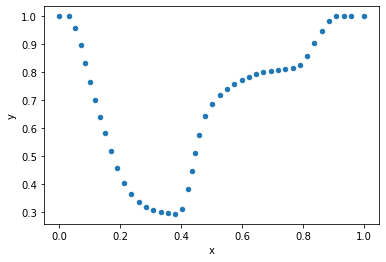

In [11]:
vl_df.plot(x="x", y="y", kind="scatter")

# Smooth original data

In [12]:
from scipy import fftpack
def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [13]:
smooth_pr = smooth_data_fft(pr_df["y"].values, 0.01)
smooth_vl = smooth_data_fft(vl_df["y"].values, 0.01)

# Interpolate data 
so that they have same dimension

In [14]:
# Define  new x_space
xmin = max(pr_df["x"].min(), vl_df["x"].min())
xmax = min(pr_df["x"].max(), vl_df["x"].max()) 

x_space = [xmin, 0.15, 0.25, 0.36, 0.399, xmax]
x_cnt = [150, 150, 150, 150, 150, 150]
x_new = np.array([])

for i in range(len(x_space) - 1):
    bp1 = x_space[i]
    bp2 = x_space[i+1]
    x_s = np.linspace(bp1, bp2, x_cnt[i])
    x_new = np.append(x_new, x_s)

In [15]:
# define an interpolation wrapper
from scipy.interpolate import interp1d
def interp_wrap(x,y,x_new, kind='linear'):
    f = interp1d(x, y, kind=kind)
    y_new = f(x_new)
    return y_new.reshape((y_new.shape[0], 1))


In [16]:
print(len(vl_df["x"]), len(vl_df["y"]) )

46 46


In [17]:
# interpolate pressure and volume
pressure_interp = interp_wrap(pr_df["x"], pr_df["y"], x_new)
volume_interp   = interp_wrap(vl_df["x"], vl_df["y"], x_new, kind="quadratic")

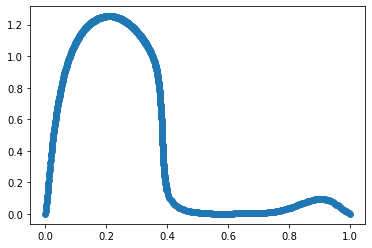

In [18]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

ax.scatter(x_new, pressure_interp)
plt.show()

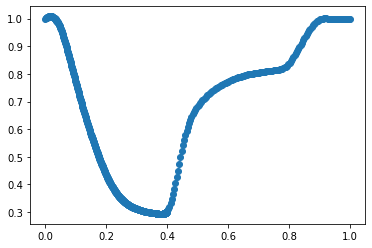

In [19]:
fig, ax = plt.subplots()

ax.scatter(x_new, volume_interp)
plt.show()

In [20]:
smooth_pr = smooth_data_fft(pressure_interp, 0.0001)
smooth_vl = smooth_data_fft(volume_interp, 0.0001)

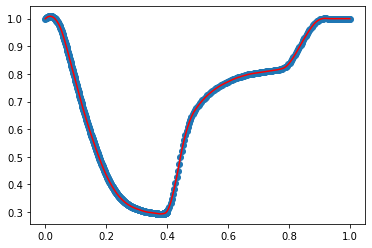

In [21]:
fig, ax = plt.subplots()

ax.scatter(x_new, volume_interp)
ax.plot(x_new, smooth_vl, c="r")

plt.show()

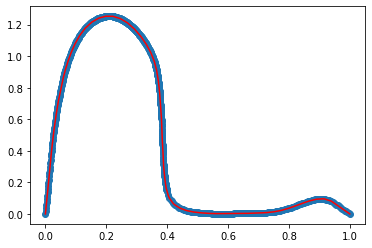

In [22]:
fig, ax = plt.subplots()

ax.scatter(x_new, pressure_interp)
ax.plot(x_new, smooth_pr, c="r")

plt.show()

In [23]:
# combine into df

data = np.hstack([smooth_pr, smooth_vl])
df = pd.DataFrame(data, columns=["pressure", "volume"])

<AxesSubplot:xlabel='pressure', ylabel='volume'>

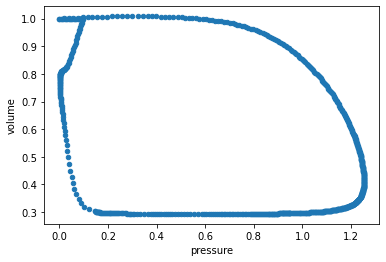

In [24]:
df.plot(x="pressure", y="volume", kind="scatter")

In [25]:
from os import path, curdir

outdir = path.join(curdir, "out")
pickle_file = path.join(outdir, "pv_curve.pickle")
excel_file = path.join(outdir, "pv_curve.xlsm")


df.to_pickle(pickle_file)
df.to_excel(excel_file)


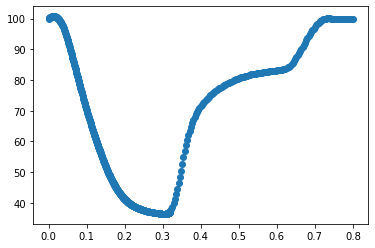

In [40]:
fig, ax = plt.subplots()

ax.scatter(x_new *0.8 , 90 * volume_interp +10)
plt.show()

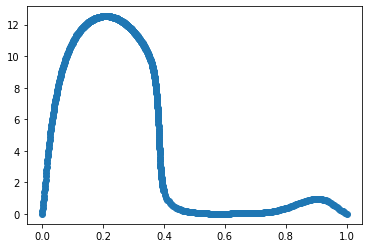

In [29]:
fig, ax = plt.subplots()

ax.scatter(x_new, 10 * pressure_interp )
plt.show()